In [1]:
import numpy as np
import torch
from scipy.stats import ortho_group

In [2]:
### more helpers

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from torch import autograd
import time
import argparse
import random
import copy
from argparse import Namespace

In [3]:
i = 230

torch.random.manual_seed(i)
torch.manual_seed(i)
random.seed(i)
np.random.seed(i)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def create_generative_model(e_tr, x_dim = 10, heteroskedastic = False, scrambled = False, partially_obs = False):
    
    list_envs = []
    if partially_obs:
        w_h_x = np.random.normal(size=(2, x_dim, x_dim))/x_dim
        w_h_y = np.random.normal(size=(x_dim, 1))/np.sqrt(x_dim)
    else:
        w_h_x = np.zeros((2, x_dim, x_dim))
        w_h_y = np.zeros((x_dim, 1))
    
    if scrambled:
        S = ortho_group.rvs(dim=2*x_dim)
    else:
        S = np.eye(x_dim*2)

    ### create env weights
    w_x_y = np.random.normal(size=(2, x_dim, 1))/np.sqrt(x_dim)
    c_e = [0. for i in range(len(e_tr)//2)] + [1. for i in range(len(e_tr)//2)]
    random.shuffle(c_e)
    index=0
    for e in e_tr:
        
        w_x_y_e = w_x_y.copy()

        if heteroskedastic:
            sigma_y = 1
            sigma_2 = e
        else:
            sigma_y = e
            sigma_2 = 1
        
        b = c_e[index]
        index+=1
        w_x_y_e[1] = w_x_y_e[1]*b
        
        ## irm generative model
        # h_e = np.random.normal(scale=e, size=(1000, x_dim))
        # z_1 = np.random.normal(scale=e, size=(1000, x_dim)) + h_e @ w_h_x[0]
        # #a =  h_e @ w_h_y
        # #print(z_1.shape)
        # y = z_1 @ w_x_y[0] + np.random.normal(scale=sigma_y, size=(1000, 1))+ h_e @ w_h_y
        # #print((w_x_y[1]*y.reshape(-1)).shape)
        # z_2 = (w_x_y[1]*y.reshape(-1)).T + np.random.normal(scale=sigma_2, size=(1000, x_dim)) + h_e @ w_h_x[1]

        ### p-irm generative model
        h_e = np.random.normal(scale=e, size=(1000, x_dim))
        z_1 = np.random.normal(scale=e, size=(1000, x_dim)) + h_e @ w_h_x[0]
        z_2 = np.random.normal(scale=e, size=(1000, x_dim)) + h_e @ w_h_x[1]
        #a =  h_e @ w_h_y
        #print(z_1.shape)
        y = z_1 @ w_x_y_e[0] + z_2 @ w_x_y_e[1] + np.random.normal(scale=sigma_y, size=(1000, 1))+ h_e @ w_h_y
        #print((w_x_y[1]*y.reshape(-1)).shape)
        #z_2 = (w_x_y[1]*y.reshape(-1)).T + np.random.normal(scale=sigma_2, size=(1000, x_dim)) + h_e @ w_h_x[1]

        Z_concat = np.concatenate((z_1, z_2), axis=1).T
        #print(Z_concat.shape)

        X = S.dot(Z_concat).T
        print(X.shape)
        list_envs.append((X, y, S, w_x_y_e, w_h_x))

    return list_envs

In [5]:
### model/training code

class linear(torch.nn.Module):

    def __init__(self, input_dim=20, output_dim=1):

        super(linear, self).__init__()

        layers = []

        layers.append(nn.Linear(input_dim, output_dim, bias=True))

        #if(phi_dim > 1):
        #    layers.append(nn.Linear(phi_dim, output_dim)) 

        self.net = nn.Sequential(*layers)

    def forward(self, x):
      
      return self.net(x)


def penalty(out, y, criterion, device):
    scale = torch.tensor(1.).to(device).requires_grad_()
    loss = criterion(out * scale, y)
    grad = autograd.grad(loss, [scale], create_graph=True)[0]
    return torch.sum(grad**2)


def train_model(envs, model, optim, args):

    p_weight = args.penalty_weight
    penalty_anneal_epoch = args.penalty_anneal_epoch
    method = args.method
    criterion = args.loss_fxn
    pen_criterion = args.pen_criterion
    epochs = args.epochs
    print_step = args.print_step

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    model = model.to(device)
    optimizer = optim    
    d_num = len(envs)
    
    train_loss_ls = []
    min_loss = 1e2 

    print("number of envs: ", d_num)
    max_val = 0
    
    
    model.train()
    model.to(torch.float)

    for epoch in range(epochs):
        
        #val_acc_ls_epoch = []
        #train_acc_ls_epoch = []
        train_loss_ls_epoch = []

        if(epoch == 0):
            print("Training Model")    
            print("Method: ", args.method)

        #print("Epoch: ", epoch)    
        num_samples = 0
        for i in range(d_num):

            train_input = torch.from_numpy(envs[i]["data"]).to(device).to(torch.float)
            train_label = torch.from_numpy(envs[i]["label"]).to(device).to(torch.float)
            
            output = model(train_input)

            ### reduction = sum
            num_samples += train_input.size(0) 
            envs[i]['loss'] = criterion(output, train_label)
            #envs[i]['acc'] = mean_accuracy(logits, train_label)
            envs[i]['penalty'] = penalty(output, train_label, pen_criterion, device)

        train_loss = (torch.stack([envs[i]['loss'] for i in range(d_num)]).sum())/num_samples
        train_loss_ls.append(train_loss.item())

        if method == 'irm':
            
            train_penalty = torch.stack([envs[i]['penalty'] for i in range(d_num) if (envs[i]['penalty_condition'] == True)]).mean()
            penalty_weight = (p_weight if epoch >= penalty_anneal_epoch else 0.)
            train_loss += penalty_weight * train_penalty
            if penalty_weight > 1.0:
                train_loss /= penalty_weight
        elif method == 'erm':
            penalty_weight = 0.

            ### set penalty to 0
            train_penalty = envs[d_num[0]]['penalty'] * 0.  # so that this term is a tensor
        else:
            raise NotImplementedError    

        model.zero_grad()
        train_loss.backward()
        optimizer.step()      

        if (epoch+1) % (print_step) == 0 or (epoch+1) == penalty_anneal_epoch:
            print(f'Epoch: {epoch+1} | Training Loss: {train_loss_ls[epoch]:.3f}')
            print(train_penalty)
            feat_vec = model.net[0].weight.detach().clone().to("cpu").numpy().T
            print("norm_feat_1:", np.linalg.norm(feat_vec[:10]))
            print("norm_feat_2:", np.linalg.norm(feat_vec[10:]))

    return train_loss_ls[-1], model.net[0].weight.detach().clone().to("cpu").numpy().T

In [6]:
def get_performance(train_envs, opt, seeds=3, method = 'irm'):

    opt.method = method
    train_losses = []
    feat_vectors = []

    for i in range(seeds):

        #torch.random.manual_seed(i)
        
        #my_model = feedforward(num_hiddenlayers=opt.hidden_layers, hidden_width=opt.hidden_width)
        my_model = linear(input_dim=opt.x_dim*2)
        optimizer = torch.optim.Adam(my_model.parameters(), lr=1e-2)
        train_loss, feature_vector = train_model(train_envs, my_model, optimizer, opt)

        feat_vectors.append(feature_vector)

    return train_losses, feat_vectors

In [7]:
#np.random.seed(230)
#torch.manual_seed(230)

my_list = create_generative_model({0.2, 1, 2, 5})

my_train_envs = []
for i in my_list:
  my_dict = {}
  my_dict["data"] = i[0]
  my_dict["label"] = i[1]
  my_dict["S"] = i[2]
  my_dict["true_wts"] = i[3]
  my_dict["penalty_condition"] = True

  my_train_envs.append(my_dict)

(1000, 20)
(1000, 20)
(1000, 20)
(1000, 20)


In [8]:
for i in my_train_envs:
  wts = i["true_wts"]
  print("norm_feat_1:", np.linalg.norm(wts[0]))
  print("norm_feat_2:", np.linalg.norm(wts[1]))

norm_feat_1: 1.0190515812794492
norm_feat_2: 1.232877303258899
norm_feat_1: 1.0190515812794492
norm_feat_2: 0.0
norm_feat_1: 1.0190515812794492
norm_feat_2: 1.232877303258899
norm_feat_1: 1.0190515812794492
norm_feat_2: 0.0


In [9]:
opt = Namespace()
opt.penalty_weight = 1e3
opt.x_dim = 10
#opt.penalty_anneal_epoch = 1000'
#opt.method = 'irm'
opt.loss_fxn = torch.nn.MSELoss(reduction='sum')
opt.epochs = 40000
opt.pen_criterion = torch.nn.MSELoss(reduction='mean')
opt.print_step = 40000
opt.penalty_anneal_epoch = 4000

In [10]:
#np.random.seed(230)
#torch.manual_seed(230)

act_norm = []
learned_norm = []

for seed in range(5):
  
  my_list = create_generative_model({0.2, 1, 2, 5})
  my_train_envs = []
  ct=0
  for i in my_list:
      my_dict = {}
      my_dict["data"] = i[0]
      my_dict["label"] = i[1]
      my_dict["S"] = i[2]
      my_dict["true_wts"] = i[3]
      my_dict["penalty_condition"] = True

      my_train_envs.append(my_dict)
  
  for i in my_train_envs:
      wts = i["true_wts"]
      # print("norm_feat_1:", np.linalg.norm(wts[0]))
      # print("norm_feat_2:", np.linalg.norm(wts[1]))

  for j in my_train_envs:
    wts = j["true_wts"]
    feat_1_norm = np.linalg.norm(wts[0])
    feat_2_norm = np.linalg.norm(wts[1])

    if(feat_2_norm>0 and ct==0):
      act_norm.append((feat_1_norm, feat_2_norm))
      ct += 1
  
  # else:
  a, b = get_performance(my_train_envs, opt, seeds=1, method='irm')
  learned_norm.append((np.linalg.norm(b[0][:10]), np.linalg.norm(b[0][10:])))

  print("ratio 1:", learned_norm[-1][0]/act_norm[-1][0])
  print("ratio 2:", learned_norm[-1][1]/act_norm[-1][1])

(1000, 20)
(1000, 20)
(1000, 20)
(1000, 20)
number of envs:  4
Training Model
Method:  irm
Epoch: 4000 | Training Loss: 8.137
tensor(19.3856, grad_fn=<MeanBackward0>)
norm_feat_1: 1.0879968
norm_feat_2: 0.7862485
Epoch: 40000 | Training Loss: 13.090
tensor(3.0260e-06, grad_fn=<MeanBackward0>)
norm_feat_1: 1.0301751
norm_feat_2: 0.22118486
ratio 1: 0.9463308961048553
ratio 2: 0.22749294367821862
(1000, 20)
(1000, 20)
(1000, 20)
(1000, 20)
number of envs:  4
Training Model
Method:  irm
Epoch: 4000 | Training Loss: 8.023
tensor(24.6172, grad_fn=<MeanBackward0>)
norm_feat_1: 1.0093901
norm_feat_2: 1.0148733
Epoch: 40000 | Training Loss: 16.788
tensor(5.9927e-05, grad_fn=<MeanBackward0>)
norm_feat_1: 0.97612756
norm_feat_2: 0.24542104
ratio 1: 0.9671293103021358
ratio 2: 0.22073402585632415
(1000, 20)
(1000, 20)
(1000, 20)
(1000, 20)
number of envs:  4
Training Model
Method:  irm
Epoch: 4000 | Training Loss: 7.397
tensor(0.0008, grad_fn=<MeanBackward0>)
norm_feat_1: 0.5735995
norm_feat_2: 0

In [11]:
ratios_1 = []
ratios_2 = []
for seed in range(5):
    ratios_1.append(learned_norm[seed][0]/act_norm[seed][0])
    ratios_2.append(learned_norm[seed][1]/act_norm[seed][1])

In [12]:
materials = ['feature_1 (invariant)', 'feature_2 (non-invariant)']
x_pos = np.arange(len(materials))
CTEs = [np.mean(ratios_1), np.mean(ratios_2)]
error = [np.std(ratios_1), np.std(ratios_2)]

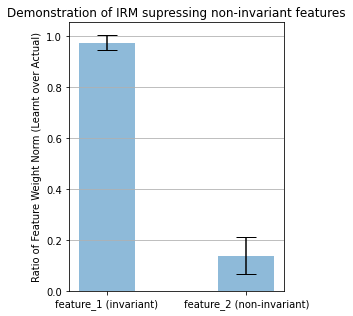

In [13]:
import matplotlib.pyplot as plt

# creating the bar plot
fig, ax = plt.subplots(figsize = (4.5, 4.5))
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, width=0.4)
ax.set_ylabel('Ratio of Feature Weight Norm (Learnt over Actual)')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Demonstration of IRM supressing non-invariant features')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()